In [1]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import sourmash
import sourmash.lca.lca_utils as lca_utils
import sourmash.tax.tax_utils as tax_utils
from tqdm import tqdm
tqdm.pandas()

sns.set(style='white')


from collections import Counter

In [2]:
sns.__version__

'0.11.0'

## Read in LCA Unique k-mer files

In [3]:
lca_files = glob.glob('../lca-unique-kmers/gtdb-rs202.*.lca-unique-kmers.txt')
lca_files

['../lca-unique-kmers/gtdb-rs202.protein-k9.lca-unique-kmers.txt',
 '../lca-unique-kmers/gtdb-rs202.nucleotide-k51.lca-unique-kmers.txt',
 '../lca-unique-kmers/gtdb-rs202.protein-k8.lca-unique-kmers.txt',
 '../lca-unique-kmers/gtdb-rs202.protein-k7.lca-unique-kmers.txt',
 '../lca-unique-kmers/gtdb-rs202.nucleotide-k31.lca-unique-kmers.txt',
 '../lca-unique-kmers/gtdb-rs202.protein-k10.lca-unique-kmers.txt',
 '../lca-unique-kmers/gtdb-rs202.nucleotide-k21.lca-unique-kmers.txt',
 '../lca-unique-kmers/gtdb-rs202.protein-k11.lca-unique-kmers.txt']

In [4]:
dfs = []
for csv in lca_files:
    df=pd.read_csv(csv, sep=',')
    df['alpha-ksize'] = os.path.basename(csv).split(".")[1]
    dfs.append(df)

In [5]:
lca_df = pd.concat(dfs)
lca_df.tail()

,rank,lineage,num_unique_kmers,f_unique_kmers,alpha-ksize
24887,genus,d__Archaea;p__Halobacteriota;c__Halobacteria;o...,1,8.617468e-08,protein-k11
24888,family,d__Archaea;p__Micrarchaeota;c__Micrarchaeia;o_...,1,8.617468e-08,protein-k11
24889,genus,d__Archaea;p__Nanoarchaeota;c__Nanoarchaeia;o_...,1,8.617468e-08,protein-k11
24890,family,d__Archaea;p__Nanoarchaeota;c__Nanoarchaeia;o_...,1,8.617468e-08,protein-k11
24891,family,d__Archaea;p__Nanoarchaeota;c__Nanoarchaeia;o_...,1,8.617468e-08,protein-k11


In [6]:
lca_df[lca_df['rank'] == 'phylum'].head()

,rank,lineage,num_unique_kmers,f_unique_kmers,alpha-ksize
2,phylum,d__Bacteria;p__Proteobacteria,149032,0.014227,protein-k9
17,phylum,d__Bacteria;p__Actinobacteriota,27218,0.002598,protein-k9
37,phylum,d__Bacteria;p__Firmicutes_A,11249,0.001074,protein-k9
42,phylum,d__Bacteria;p__Bacteroidota,10965,0.001047,protein-k9
136,phylum,d__Bacteria;p__Desulfobacterota,3295,0.000315,protein-k9


## Read in gtdb taxonomy and count genomes per lineage

In [7]:
tax = pd.read_csv('gtdb-rs202.taxonomy.v2.with-strain.csv')
tax["lin"] = tax['superkingdom'] + ';' \
           + tax['phylum'] + ';' \
           + tax['class'] + ';' \
           + tax['order'] + ';' \
            + tax['family'] + ';' \
               + tax['genus'] + ';'\
            + tax['species'] + ';' \
            + tax['strain']
all_lins = tax["lin"]

In [8]:
# count occurrence of each lineage at each rank
linC = Counter()
for lin in all_lins:
    smashlin = lca_utils.make_lineage(lin)
    for rank in tax_utils.ascending_taxlist(include_strain=True):
        rank_lin = lca_utils.pop_to_rank(smashlin, rank)
        linC[rank_lin] +=1

In [9]:
linC.most_common(2)

[((LineagePair(rank='superkingdom', name='d__Bacteria'),), 254090),
 ((LineagePair(rank='superkingdom', name='d__Bacteria'),
   LineagePair(rank='phylum', name='p__Proteobacteria')),
  120757)]

## Get count per lineage in lca_unique_kmers df

In [10]:
def get_lineage_count(row):
    lin = row["lineage"]
    smashlin = lca_utils.make_lineage(lin)
    return linC[smashlin]

In [11]:
lca_df['count'] = lca_df.progress_apply(get_lineage_count, axis=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 181314/181314 [00:04<00:00, 37922.33it/s]


In [12]:
lca_df.head()

,rank,lineage,num_unique_kmers,f_unique_kmers,alpha-ksize,count
0,superkingdom,d__Bacteria,2792938,0.266628,protein-k9,254090
1,no_lca,no_lin,268323,0.025615,protein-k9,0
2,phylum,d__Bacteria;p__Proteobacteria,149032,0.014227,protein-k9,120757
3,class,d__Bacteria;p__Actinobacteriota;c__Actinomycetia,109148,0.010420,protein-k9,21459
4,class,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,106983,0.010213,protein-k9,104665


In [13]:
lca_df["rank"].unique()

array(['superkingdom', 'no_lca', 'phylum', 'class', 'genus', 'family',
       'order', 'species'], dtype=object)

In [14]:
lca_df[lca_df['rank'] == 'superkingdom']

,rank,lineage,num_unique_kmers,f_unique_kmers,alpha-ksize,count
0,superkingdom,d__Bacteria,2792938,0.266628,protein-k9,254090
87,superkingdom,d__Archaea,4853,0.000463,protein-k9,4316
2,superkingdom,d__Bacteria,32418,0.005418,nucleotide-k51,254090
11622,superkingdom,d__Archaea,166,0.000028,nucleotide-k51,4316
0,superkingdom,d__Bacteria,3604357,0.578656,protein-k8,254090
44,superkingdom,d__Archaea,2656,0.000426,protein-k8,4316
0,superkingdom,d__Bacteria,617559,0.585295,protein-k7,254090
30,superkingdom,d__Archaea,158,0.000150,protein-k7,4316
2,superkingdom,d__Bacteria,51067,0.009000,nucleotide-k31,254090
9603,superkingdom,d__Archaea,207,0.000036,nucleotide-k31,4316


In [15]:
lca_df[lca_df['rank'] == 'strain']

,rank,lineage,num_unique_kmers,f_unique_kmers,alpha-ksize,count


In [16]:
lca_df[lca_df['rank'] == 'class'].head()

,rank,lineage,num_unique_kmers,f_unique_kmers,alpha-ksize,count
3,class,d__Bacteria;p__Actinobacteriota;c__Actinomycetia,109148,0.010420,protein-k9,21459
4,class,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,106983,0.010213,protein-k9,104665
6,class,d__Bacteria;p__Bacteroidota;c__Bacteroidia,73018,0.006971,protein-k9,12772
7,class,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,69189,0.006605,protein-k9,16016
10,class,d__Bacteria;p__Firmicutes;c__Bacilli,35895,0.003427,protein-k9,53835


In [17]:
lca_df[lca_df['rank'] == 'class'].describe()#.agg('f_unique_kmers')

,num_unique_kmers,f_unique_kmers,count
count,922.000000,9.220000e+02,922.000000
mean,1879.934924,2.286709e-04,2158.900217
std,10278.272238,1.180014e-03,11177.655707
min,1.000000,8.617468e-08,2.000000
25%,3.000000,4.865593e-07,33.000000
50%,13.500000,1.926522e-06,86.500000
75%,69.750000,8.787478e-06,296.000000
max,109148.000000,1.369892e-02,104665.000000


## Recreate LCA rankinfo stacked bar via cumsum


In [18]:
taxlist = list(lca_utils.taxlist(include_strain=False))
#taxlist.append('genome')
taxlist = ['no_lca'] + taxlist# + ['genome']

print(taxlist)

asctaxlist = list(tax_utils.ascending_taxlist(include_strain=False))
asctaxlist = asctaxlist + ['no_lca']

#asctaxlist = ['genome'] + asctaxlist + ['no_lca']
print(asctaxlist)

['no_lca', 'superkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
['species', 'genus', 'family', 'order', 'class', 'phylum', 'superkingdom', 'no_lca']


In [19]:
korder=['protein-k7', 'protein-k8','protein-k9', 'protein-k10','protein-k11','nucleotide-k21','nucleotide-k31','nucleotide-k51']


In [20]:
# groupby and make separate alphabet, ksize cols
sum_funique_kmers = lca_df.groupby(['alpha-ksize', 'rank'])['f_unique_kmers'].agg('sum').reset_index()
sum_funique_kmers[['alphabet','ksize']] = sum_funique_kmers['alpha-ksize'].str.split('-', expand=True)

# reorder by ascending taxlist so we can get ranks in the right order
sum_funique_kmers.set_index(['rank', 'alpha-ksize'], inplace=True)
sum_funique_kmers = sum_funique_kmers.reindex(asctaxlist, level='rank')
# remove index
sum_funique_kmers.reset_index()

# now that ranks are properly ordered, cumsum f_unique_kmers up the ranks
sum_funique_kmers['cumsum_funique_kmers'] = sum_funique_kmers.groupby('alpha-ksize')['f_unique_kmers'].transform(pd.Series.cumsum)
sum_funique_kmers.reset_index(inplace=True)
sum_funique_kmers#[sum_funique_kmers['rank'] == 'phylum']

# for nicer plotting, reorder alpha-ksize
sum_funique_kmers.set_index(['rank','alpha-ksize'], inplace=True)
sum_funique_kmers = sum_funique_kmers.reindex(korder, level='alpha-ksize')
sum_funique_kmers.reset_index(inplace=True)
sum_funique_kmers

,rank,alpha-ksize,f_unique_kmers,alphabet,ksize,cumsum_funique_kmers
0,species,protein-k7,0.029549,protein,k7,0.029549
1,species,protein-k8,0.149734,protein,k8,0.149734
2,species,protein-k9,0.370325,protein,k9,0.370325
3,species,protein-k10,0.505471,protein,k10,0.505471
4,species,protein-k11,0.550306,protein,k11,0.550306
...,...,...,...,...,...,...
59,no_lca,protein-k10,0.006750,protein,k10,1.000000
60,no_lca,protein-k11,0.003008,protein,k11,1.000000
61,no_lca,nucleotide-k21,0.016824,nucleotide,k21,1.000000
62,no_lca,nucleotide-k31,0.000440,nucleotide,k31,1.000000


In [21]:
rank_colors = dict(zip(asctaxlist, sns.color_palette('Set2', 8).as_hex()))
rank_colors

{'species': '#66c2a5',
 'genus': '#fc8d62',
 'family': '#8da0cb',
 'order': '#e78ac3',
 'class': '#a6d854',
 'phylum': '#ffd92f',
 'superkingdom': '#e5c494',
 'no_lca': '#b3b3b3'}

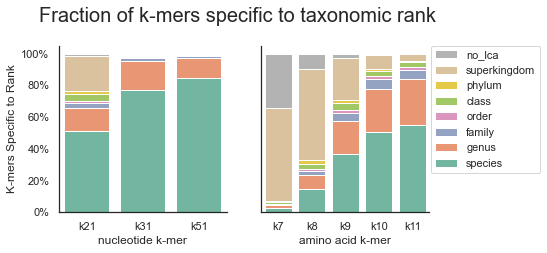

In [22]:
alphabets = ['nucleotide','protein']
g = sns.FacetGrid(sum_funique_kmers, col = 'alphabet', sharex=False)# hue = 'rank', hue_order = taxlist,
for n, ax in enumerate(g.fig.axes):
    alpha = alphabets[n]
    df = sum_funique_kmers[sum_funique_kmers['alphabet'] == alpha]
    for idx, rank in enumerate(taxlist):
        ds = df[df['rank'] == rank]
        ds.set_index('alpha-ksize', inplace=True)
        #print(ds)
        bar1 = sns.barplot(data=ds, ax=ax , x="ksize",  y="cumsum_funique_kmers",label=rank, color=rank_colors[rank])
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))
    #ax.set_title(alpha, size=12)
    if n == 0:
        ax.set_ylabel("K-mers Specific to Rank", size=12)      
        ax.axes.get_xaxis().set_label_text("nucleotide k-mer")
    if n == 1:
        ax.yaxis.get_label().set_visible(False)
        ax.axes.get_xaxis().set_label_text("amino acid k-mer")
        #ax.yaxis.set_label_text('Percent K-mers Specific at Rank')#.set_visible(False)    
# legend
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)

g.fig.suptitle("Fraction of k-mers specific to taxonomic rank", x=0.5, y=1.10, size=20)
g.savefig("gtdb-rs202.lca_f_unique_kmers.v2.pdf",bbox_inches='tight')
g.savefig("gtdb-rs202.lca_f_unique_kmers.v2.png",bbox_inches='tight')